In [1]:
# load modules (install floris)
from floris.floris import Floris
import matplotlib.pyplot as plt
import numpy as np
import scipy
import GPy
import random
import time
from visualization_manager import VisualizationManager
from pygmo import hypervolume

# Visualization
from copy import deepcopy
from pareto import Pareto
from scipy.optimize import minimize
from scipy.stats import norm
from pareto import Pareto
from BayesianOpt import *
from pygmo import hypervolume
%matplotlib inline

In [2]:
def visualizeWake(floris,wd, ws, yawAngle):
    floris.farm.flow_field.wind_direction = np.radians(wd-270) # frame of reference is west
    floris.farm.flow_field.wind_speed = ws
    floris.farm.flow_field.initial_flowfield = floris.farm.flow_field._initial_flowfield()
    floris.farm.flow_field.u_field = floris.farm.flow_field._initial_flowfield()
    turbines    = [turbine for _, turbine in floris.farm.flow_field.turbine_map.items()]
    for k,turbine in enumerate(turbines):
        turbine.yaw_angle = np.radians(yawAngle[k])
    
    ff_viz = deepcopy(floris.farm.flow_field)
    plt.xlim([0,600])
    grid_resolution = (100, 100, 25)
    visualization_manager = VisualizationManager(ff_viz, grid_resolution)
    visualization_manager.plot_z_planes([0.5])
    

In [3]:
def windFarmPower(floris,wd, ws, yawAngle,scale):
    
    #set up wind direction and speed
    floris.farm.flow_field.wind_direction = np.radians(wd - 270) # frame of reference is west
    floris.farm.flow_field.wind_speed = ws
    floris.farm.flow_field.initial_flowfield = floris.farm.flow_field._initial_flowfield()
    floris.farm.flow_field.u_field = floris.farm.flow_field._initial_flowfield()
    
    
    turbines    = [turbine for _, turbine in floris.farm.flow_field.turbine_map.items()]
    for k,turbine in enumerate(turbines):
        turbine.yaw_angle = np.radians(yawAngle[k])
    floris.farm.flow_field.calculate_wake()
    
    power = np.zeros([len(yawAngle),1])
    totalPower = 0.0
    for i, turbine in enumerate(turbines):
        power[i]=turbine.power
        totalPower = totalPower + turbine.power    
    
    return power/scale, totalPower/scale/len(turbines)

#run wind farm configuration input with a single wind turbine
floris = Floris("example_input_single.json")
numWT = 1
scale = 1.0
#conventional default input is yawAngle = 0 degree
yawAngle0 = np.zeros(numWT)

#compute the wind turbine power vector and total wind farm power (for single wind turbine they are the same)
powerSingle,totalPower = windFarmPower(floris,0, 8, yawAngle0,scale)

floris = Floris("example_input_9.json")
num_tur = len(floris.farm.flow_field.turbine_map.items())

In [4]:
def expected_improvement(Xcand, gp_model, current_min, wind_dir):
    Xcand = np.atleast_2d(Xcand)
    Xcand = np.hstack((Xcand, np.ones((len(Xcand), 1)) * wind_dir))
    mu, var = gp_model.predict(Xcand)
    sigma = np.sqrt(var)
    
    Z = (current_min - mu) / sigma
    ei = (current_min - mu) * norm.cdf(Z) + sigma * norm.pdf(Z)
    
    return -ei[0]

def single_next_point(acquisition, gp_model, bounds, eval_y, wind_dir, N_mc = 5000):

    best_x = None
    best_acquisition_value = 0
    n_params = bounds.shape[0]
    current_min = np.min(eval_y)
    # Random 한 점을 많이 찍고 그 중 가장 acquisition ftn value가 높은 지점을 start 지점으로 삼아 scipy minimize 함수 작동
    points = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(N_mc, n_params))
    evaluations = acquisition(points, gp_model, current_min, wind_dir)
    idx_best = np.argmin(evaluations, axis=0)
    
    result = minimize(fun=acquisition, x0 = points[idx_best, :], bounds=bounds, method='L-BFGS-B',args=(gp_model, current_min, wind_dir))

    if result.fun <= best_acquisition_value:
        best_acquisition_value = result.fun
        best_x = result.x

    return best_x

In [5]:
def multiobj_f(yawangle):
    Y1 = np.zeros(len(yawangle))[:,None]
    Y2 = np.zeros(len(yawangle))[:,None]
    for i,angle in enumerate(yawangle):
        power,totalPower = windFarmPower(floris, angle[-1], 8, angle[:-1], powerSingle)
        Y1[i] = -totalPower
        Y2[i] = np.sum(np.square(np.radians(angle[:-1]))) / np.square(np.radians(25.0)) / num_tur
    Y = np.hstack((Y1,Y2))
    return Y

minimum_yaw_angle = 0.0
maximum_yaw_angle = 25.0

bounds = np.zeros((num_tur, 2))
for i in range(num_tur):
    bounds[i,:] = [minimum_yaw_angle, maximum_yaw_angle]
    
# number of turbines + wind context
n_params = bounds.shape[0]+1

In [6]:
current_wd = np.random.uniform(88,93)

In [7]:
trial = 500
ref_point = [0,1]

# Random strategy

In [8]:
uniform = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(trial+2, bounds.shape[0]))
initial_input = np.hstack((uniform[:2], np.ones((2,1))*current_wd))
uniform_input = np.hstack((uniform, np.ones((trial+2,1))*current_wd))
initial_output = multiobj_f(np.atleast_2d(initial_input))
uniform_output = multiobj_f(np.atleast_2d(uniform_input))

 /home/cwj/venv/local/lib/python3.5/site-packages/floris/wake_velocity.py:226: RuntimeWarning:invalid value encountered in sqrt


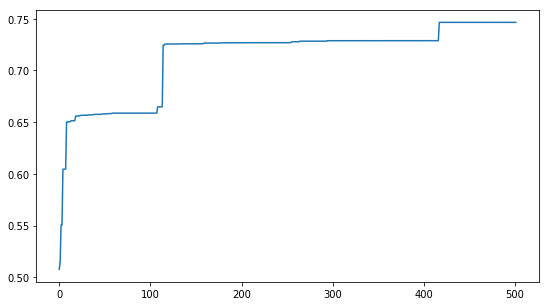

In [9]:
uni_volume = []
for i in range(len(uniform_output)):
    uni_hv = hypervolume(uniform_output[:i+1])
    v = uni_hv.compute(ref_point)
    uni_volume.append(v)
plt.figure(figsize=(9,5))
plt.plot(uni_volume)
plt.show()

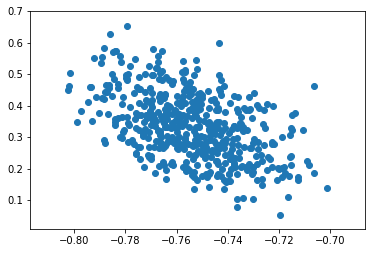

In [10]:
plt.scatter(uniform_output[:,0], uniform_output[:,1])
plt.show()

# linear scalization

In [11]:
def ls_f(yawangle):
    Y = np.zeros(len(yawangle))[:,None]
    for i,angle in enumerate(yawangle):
        power,totalPower = windFarmPower(floris, angle[-1], 8, angle[:-1], powerSingle)
        Y[i] = -totalPower/2 + np.sum(np.square(np.radians(angle[:-1]))) / np.square(np.radians(25.0)) / num_tur / 2
    return Y

In [12]:
lin_input = np.atleast_2d(initial_input)
lin_output = ls_f(lin_input) 


for i in range(trial):
    gp_model = GPy.models.GPRegression(lin_input.copy(), lin_output.copy(), kernel= GPy.kern.RBF(input_dim=n_params-1, ARD=True))
    gp_model.optimize()
    
    next_point = np.atleast_2d(single_next_point(expected_improvement, gp_model, bounds, lin_output, current_wd))
    next_point = np.hstack((next_point, np.ones((1,1)) * current_wd))
    lin_input = np.append(lin_input, next_point, axis = 0)
    function_value = ls_f(np.atleast_2d(next_point))
    lin_output = np.append(lin_output, function_value, axis = 0)

 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/core/gp.py:87: UserWarning:Your kernel has a different input dimension 9 then the given X dimension 10. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel
 /home/cwj/venv/local/lib/python3.5/site-packages/floris/wake_velocity.py:226: RuntimeWarning:invalid value encountered in sqrt


In [13]:
lin_output = multiobj_f(np.atleast_2d(lin_input))

 /home/cwj/venv/local/lib/python3.5/site-packages/floris/wake_velocity.py:226: RuntimeWarning:invalid value encountered in sqrt


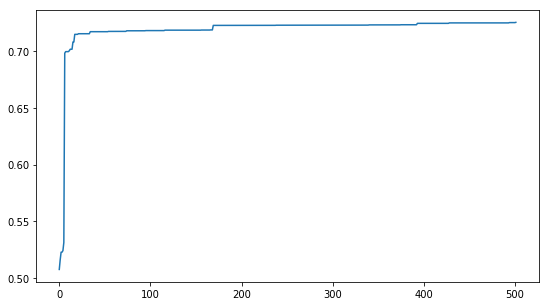

In [14]:
lin_volume = []
for i in range(len(lin_output)):
    lin_hv = hypervolume(lin_output[:i+1])
    v = lin_hv.compute(ref_point)
    lin_volume.append(v)
plt.figure(figsize=(9,5))
plt.plot(lin_volume)
plt.show()

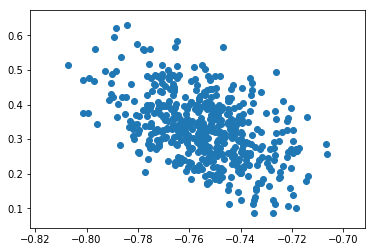

In [15]:
plt.scatter(lin_output[:,0], lin_output[:,1])
plt.show()

# No - preference method

In [16]:
def nopre_f(yawangle):
    opt = np.array([[-1, 0]])
    Y = np.zeros(len(yawangle))[:,None]
    for i,angle in enumerate(yawangle):
        power,totalPower = windFarmPower(floris, angle[-1], 8, angle[:-1], powerSingle)
        f = np.array([[-totalPower, np.sum(np.square(np.radians(angle[:-1]))) / np.square(np.radians(25.0)) / num_tur]])
        Y[i] = np.linalg.norm(f)
    return Y

In [17]:
no_input = np.atleast_2d(initial_input)
no_output = nopre_f(no_input) 


for i in range(trial):
    gp_model = GPy.models.GPRegression(no_input.copy(), no_output.copy(), kernel= GPy.kern.RBF(input_dim=n_params-1, ARD=True))
    gp_model.optimize()
    
    next_point = np.atleast_2d(single_next_point(expected_improvement, gp_model, bounds, no_output, current_wd))
    next_point = np.hstack((next_point, np.ones((1,1)) * current_wd))
    no_input = np.append(no_input, next_point, axis = 0)
    function_value = nopre_f(np.atleast_2d(next_point))
    no_output = np.append(no_output, function_value, axis = 0)

 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/core/gp.py:87: UserWarning:Your kernel has a different input dimension 9 then the given X dimension 10. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel
 /home/cwj/venv/local/lib/python3.5/site-packages/floris/wake_velocity.py:226: RuntimeWarning:invalid value encountered in sqrt


In [18]:
no_output = multiobj_f(np.atleast_2d(no_input))

 /home/cwj/venv/local/lib/python3.5/site-packages/floris/wake_velocity.py:226: RuntimeWarning:invalid value encountered in sqrt


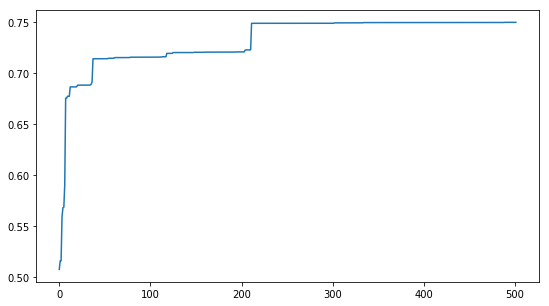

In [19]:
no_volume = []
for i in range(len(no_output)):
    no_hv = hypervolume(no_output[:i+1])
    v = no_hv.compute(ref_point)
    no_volume.append(v)
plt.figure(figsize=(9,5))
plt.plot(no_volume)
plt.show()

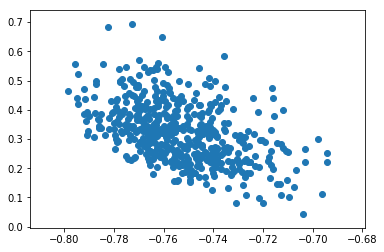

In [20]:
plt.scatter(no_output[:,0], no_output[:,1])
plt.show()

# Multi-objective Bayesian optimization

In [21]:
mbo_input = np.atleast_2d(initial_input)
mbo_output = multiobj_f(mbo_input) 

num_output = mbo_output.shape[1]

for i in range(trial):
    pareto = Pareto(np.empty((0, num_output)))
    reference = np.ones((1, num_output))
    
    gp_models = [GPy.models.GPRegression(mbo_input.copy(), mbo_output[:,[i]].copy(), kernel= GPy.kern.RBF(input_dim=n_params-1, ARD=True)) for i in range(mbo_output.shape[1])]
    for m in gp_models:
        m.optimize()
      
    pareto.update(mbo_output)
    pf = pareto.front
    f = np.max(pf, axis=0, keepdims=True) - np.min(pf, axis=0, keepdims=True)
    reference = np.max(pf, axis=0, keepdims=True) + 2 * f / pf.shape[0]
    

    next_point = np.atleast_2d(sample_next_point(EHVI, gp_models, bounds, pareto, reference, num_output, current_wd))
    next_point = np.hstack((next_point, np.ones((1,1)) * current_wd))
    mbo_input = np.append(mbo_input, next_point, axis = 0)
    function_value = multiobj_f(np.atleast_2d(next_point))
    mbo_output = np.append(mbo_output, function_value, axis = 0)

 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/core/gp.py:87: UserWarning:Your kernel has a different input dimension 9 then the given X dimension 10. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:244: RuntimeWarning:invalid value encountered in true_divide
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/rbf.py:54: RuntimeWarning:invalid value encountered in multiply
 /home/cwj/venv/local/lib/python3.5/site-packages/floris/wake_velocity.py:226

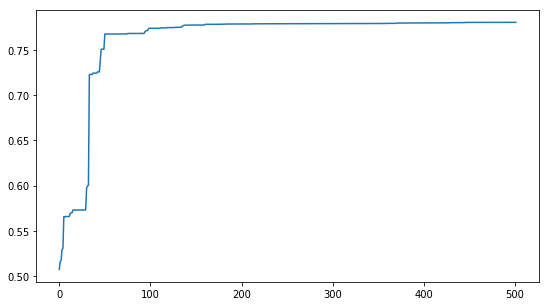

In [22]:
mbo_volume = []
for i in range(len(mbo_output)):
    mbo_hv = hypervolume(mbo_output[:i+1])
    v = mbo_hv.compute(ref_point)
    mbo_volume.append(v)
plt.figure(figsize=(9,5))
plt.plot(mbo_volume)
plt.show()

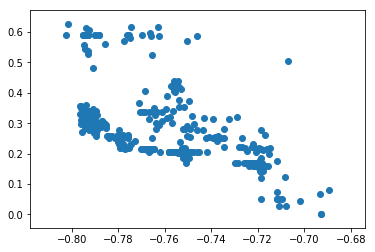

In [23]:
plt.scatter(mbo_output[:,0], mbo_output[:,1])
plt.show()

# Proposed algorithm

In [24]:
cmbo_input = np.random.uniform(np.append(np.ones(num_tur)*0,90), np.append(np.ones(num_tur)*25,120), (1,n_params)) 
cmbo_output = multiobj_f(cmbo_input) 

context_list = np.random.uniform(90, 110, size=(150, 1))
reference = np.array([[0, 1]])
num_output = cmbo_output.shape[1]

for i in range(len(context_list)):
    pareto = Pareto(np.empty((0, num_output)))
    gp_models = [GPy.models.GPRegression(cmbo_input[:].copy(), cmbo_output[:,[i]].copy(), kernel= GPy.kern.RBF(input_dim=n_params, ARD=True)) for i in range(cmbo_output.shape[1])]
    for m in gp_models:
        m.optimize()
    
    context_X = np.hstack((cmbo_input[:,:-1], np.ones((len(cmbo_input), 1)) * context_list[i]))
    preds =  [m.predict(context_X) for m in gp_models]
    context_Y, var = (np.concatenate(moment, 1) for moment in zip(*preds))
    
    pareto.update(context_Y)
    pf = pareto.front
       
    next_point = np.atleast_2d(sample_next_point(EHVI, gp_models, bounds, pareto, reference, num_output, context_list[i]))
    next_point = np.hstack((next_point, np.ones((1,1)) * context_list[i]))
    cmbo_input = np.append(cmbo_input, next_point, axis = 0)
    function_value = multiobj_f(np.atleast_2d(next_point))
    cmbo_output = np.append(cmbo_output, function_value, axis = 0)

In [25]:
cmbo_input = np.vstack((cmbo_input, np.atleast_2d(initial_input)))
cmbo_output = multiobj_f(cmbo_input) 

for i in range(trial):
    pareto = Pareto(np.empty((0, num_output)))    
    gp_models = [GPy.models.GPRegression(cmbo_input[:].copy(), cmbo_output[:,[i]].copy(), kernel= GPy.kern.RBF(input_dim=n_params, ARD=True)) for i in range(cmbo_output.shape[1])]
    for m in gp_models:
        m.optimize()
    
    context_X = np.hstack((cmbo_input[:,:-1], np.ones((len(cmbo_input), 1)) * current_wd))
    preds =  [m.predict(context_X) for m in gp_models]
    context_Y, var = (np.concatenate(moment, 1) for moment in zip(*preds))
    
    pareto.update(context_Y)
    pf = pareto.front
    
    next_point = np.atleast_2d(sample_next_point(EHVI, gp_models, bounds, pareto, reference, num_output, current_wd))
    next_point = np.hstack((next_point, np.ones((1,1)) * current_wd))
    cmbo_input = np.append(cmbo_input, next_point, axis = 0)
    function_value = multiobj_f(np.atleast_2d(next_point))
    cmbo_output = np.append(cmbo_output, function_value, axis = 0)    

 /home/cwj/venv/local/lib/python3.5/site-packages/floris/wake_velocity.py:226: RuntimeWarning:invalid value encountered in sqrt


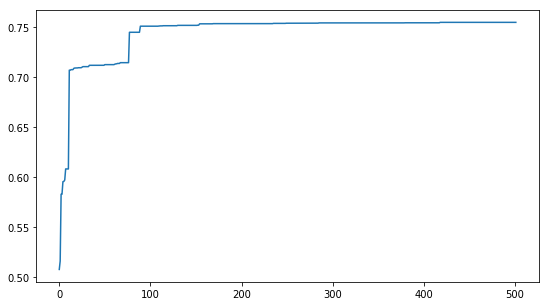

In [29]:
cmbo_volume = []
for i in range(len(cmbo_output[-trial-2:])):
    if i == 501:
        cmbo_hv = hypervolume(cmbo_output[-trial-2:])
    else:
        cmbo_hv = hypervolume(cmbo_output[-trial-2:-trial-2+i+1])
    v = cmbo_hv.compute(ref_point)
    cmbo_volume.append(v)
plt.figure(figsize=(9,5))
plt.plot(cmbo_volume)
plt.show()

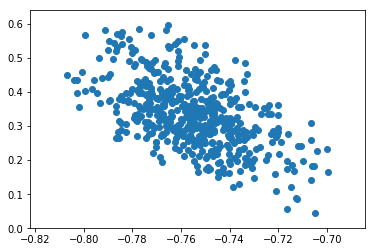

In [30]:
plt.scatter(cmbo_output[-trial-2:,0], cmbo_output[-trial-2:,1])
plt.show()

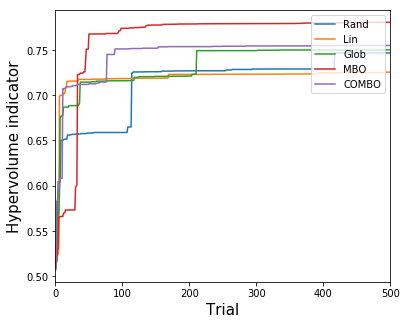

In [31]:
plt.figure(figsize=(6,5))
plt.xlim([0, trial])

# plt.title('Optimal input', fontsize = 12)
plt.xlabel('Trial', fontsize = 15)
plt.ylabel('Hypervolume indicator', fontsize = 15)

plt.plot(np.arange(trial+2), uni_volume, label = 'Rand')
plt.plot(np.arange(trial+2), lin_volume, label = 'Lin')
plt.plot(np.arange(trial+2), no_volume, label = 'Glob')
plt.plot(np.arange(trial+2), mbo_volume, label = 'MBO')
plt.plot(np.arange(trial+2), cmbo_volume, label = 'COMBO')

plt.legend(loc=1)
# plt.savefig('turbine2.png',bbox_inches='tight')
plt.show()

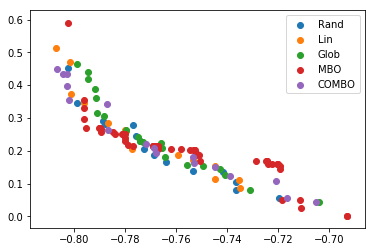

In [32]:
pareto = Pareto(np.empty((0, num_output)))
pareto.update(uniform_output)
uni_pf = pareto.front

pareto = Pareto(np.empty((0, num_output)))
pareto.update(lin_output)
lin_pf = pareto.front

pareto = Pareto(np.empty((0, num_output)))
pareto.update(no_output)
no_pf = pareto.front

pareto = Pareto(np.empty((0, num_output)))
pareto.update(mbo_output)
mbo_pf = pareto.front

pareto = Pareto(np.empty((0, num_output)))
pareto.update(cmbo_output[-trial-2:])
cmbo_pf = pareto.front

plt.scatter(uni_pf[:,0], uni_pf[:,1], label = 'Rand')
plt.scatter(lin_pf[:,0], lin_pf[:,1], label = 'Lin')
plt.scatter(no_pf[:,0], no_pf[:,1], label = 'Glob')
plt.scatter(mbo_pf[:,0], mbo_pf[:,1], label = 'MBO')
plt.scatter(cmbo_pf[:,0], cmbo_pf[:,1], label = 'COMBO')
plt.legend(loc=1)
plt.show()